<a href="https://colab.research.google.com/github/keisyashakila/CW5-MSCI151-KEISYA-IRWANSYAH/blob/main/KEISYA_FINAL_MILP_CW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd

df = pd.read_excel("/content/sample_data/CW5 availability.xlsx")


In [39]:
from collections import defaultdict
import os
import csv

Correcting import statements:
- `from collection import dafaultdict` to `from collections import defaultdict`
- Assuming `import css` was intended as `import csv` as `css` is not a standard Python module.

In [40]:
from collections import defaultdict
import os
import csv

In [41]:
def save_schedule_csv(filename, hours_by_barista, schedule, days, blocks):
    """
    Save summary CSV with two parts: hours per barista and daily schedule table.
    """
    # Make sure the results folder exists
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)

        # Part 1: Weekly hours per barista
        writer.writerow(["--- Weekly hours per barista ---"])
        writer.writerow(["Barista", "Hours"])
        for o, hrs in hours_by_barista.items():
            writer.writerow([o, hrs])

        writer.writerow([])  # blank line

        # Part 2: Daily schedule
        writer.writerow(["--- Daily schedule ---"])
        header = ["Day/Block"] + [str(b) for b in blocks]   # use block names/IDs
        writer.writerow(header)

        for d in days:
            row = [str(d)]  # day name/ID
            for b in blocks:
                names = schedule.get(d, {}).get(b, [])
                row.append(";".join(names) if names else "")
            writer.writerow(row)

In [42]:
!pip install pulp

In [43]:
import pulp as pl

In [44]:
# reference to uploaded coursework pdf (local path)
CW5_PDF_PATH = "/content/sample_data/CW5_MSCI151_released.pdf"

In [45]:
baristas = ["Max", "Jiwa", "Fore", "Donna", "Paul"]
days = list(range(1,7))
blocks = list(range(1,5))
H = 4

days 1-7, due to 7 days a week

In [46]:
cost = {"Max": 50000, "Jiwa": 50000, "Fore": 50000, "Donna": 150000, "Paul": 150000}
etype = {"Max": "P", "Jiwa": "P", "Fore": "P", "Donna": "F", "Paul": "F"}
minWeekly_default = {"Max": 12, "Jiwa": 12, "Fore": 12, "Donna": 36, "Paul": 36}

In [47]:
avail = {("Max", 1): 8, ("Max", 2): 8, ("Max", 3): 8, ("Max", 4): 0, ("Max", 5): 8, ("Max", 6): 4, ("Max", 7): 4, ("Jiwa", 1): 4, ("Jiwa", 2): 4, ("Jiwa", 3): 8, ("Jiwa", 4): 8, ("Jiwa", 5): 0, ("Jiwa", 6): 4, ("Jiwa", 7): 0, ("Fore", 1): 8, ("Fore", 2): 0, ("Fore", 3): 8, ("Fore", 4): 8, ("Fore", 5): 8, ("Fore", 6): 8, ("Fore", 7): 0, ("Donna", 1): 12, ("Donna", 2): 12, ("Donna", 3): 12, ("Donna", 4): 12, ("Donna", 5): 12, ("Donna", 6): 12, ("Donna", 7): 8, ("Paul", 1): 12, ("Paul", 2): 8, ("Paul", 3): 12, ("Paul", 4): 12, ("Paul", 5): 8, ("Paul", 6): 12, ("Paul", 7): 12}

In [48]:
days = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}

In [49]:
blocks = {1: "07:00-11:00", 2: "11:00-15:00", 3: "15:00-19:00", 4: "19:00-23:00"}
block_ids = list(blocks.keys())

In [50]:
def print_schedule(y_vars):
    for d in days:
        print(f"\n{day_names[d]}")
        for b in block_ids:
            assigned = [o for o in baristas if y_vars[o, d, b].varValue == 1]
            print(f"  Block {b} ({blocks[b]}): {', '.join(assigned) if assigned else 'None'}")

mathematical model

In [51]:
model = pl.LpProblem("Barista_Scheduling", pl.LpMinimize)

decision variable ​￼

In [52]:
y = pl.LpVariable.dicts(
    "y",
    ((o, d, b) for o in baristas for d in days for b in blocks),
    cat="Binary"
)

Minimise Cost

In [53]:
model += pl.lpSum(H * cost[o] * y[o, d, b] for o in baristas for d in days for b in blocks), "TotalCost"

In [54]:
# --- Baseline Model ---
baseline_model = pl.LpProblem("Cafe_Baseline", pl.LpMinimize)

# Decision variables
y_base = pl.LpVariable.dicts("assign_base", (baristas, days, block_ids), cat="Binary")

# Weekly hours
Hbar_base = {o: H * pl.lpSum(y_base[o][d][b] for d in days for b in block_ids) for o in baristas}


# **Constraints**

Coverage (one barista per block)

In [55]:
for d in days:
    for b in blocks:
        model += pl.lpSum(y[o, d, b] for o in baristas) >= 1

Per‑day availability (hours)

In [56]:
for o in baristas:
    for d in days:
        model += H * pl.lpSum(y[o, d, b] for b in blocks) <= avail[(o, d)]

Daily block limit

In [57]:
for o in baristas:
    for d in days:
        if etype[o] == "P":  # Part-time
            model += pl.lpSum(y[o, d, b] for b in blocks) == 2
        else:  # Full-time
            model += pl.lpSum(y[o, d, b] for b in blocks) == 3

Weekly minimum hours

In [58]:
for o in baristas:
    model += H * pl.lpSum(y[o, d, b] for d in days for b in blocks) >= minWeekly_default[o]

Binary variables (the problem)

*   **cat="Binary"** part automatically enforces that each variable is either 0 or 1.

## **Big Picture**

•  Coverage → shop never empty.

•  Per-day Availability → respect daily limits.

•  Daily limits → enforce part/full-time rules.

•  Weekly minimums → guarantee fair hours.

•  Binary variables → clean yes/no assignments.

---
This show each assignment of a barista to a block on a day as yes/no. Then, it will choose which are yes (1) and which are no (0)


# **Solving part**

Solve the Model

In [59]:
def extract_results(model, y, baristas, days, blocks, allow_blocks, H):
    """
    Extract solver status, objective, hours per barista, and schedule (daily x block).
    """
    status = pl.LpStatus[model.status]
    total_cost = pl.value(model.objective)

    hours_by_barista = {o: 0 for o in baristas}
    schedule = defaultdict(lambda: defaultdict(list))  # schedule[d][b] -> list of baristas

    for o in baristas:
        for d in days:
            for b in allow_blocks[d]:
                val = y[(o, d, b)].value()
                if val is not None and val > 0.5:
                    hours_by_barista[o] += H
                    schedule[d][b].append(o)

    return status, total_cost, hours_by_barista, schedule


In [60]:
def print_summary(title, status, total_cost, hours_by_barista, schedule):
    print("\n" + "=" * 72)
    print(title)
    print("=" * 72)
    print(f"Solver status: {status}")
    if total_cost is not None:
        print(f"Total weekly cost (IDR): {int(total_cost):,}")
    print("\nWeekly hours per barista:")
    for o in hours_by_barista:
        print(f"  - {o:6s}: {hours_by_barista[o]:2d} hours")

    print("\nDaily × Block schedule:")
    for d in sorted(schedule.keys()):
        print(f"  {days[d]}:")
        for b in sorted(schedule[d].keys()):
            who = ", ".join(schedule[d][b]) if schedule[d][b] else "(none)"
            print(f"    [{blocks[b]}] → {who}")
    print("=" * 72 + "\n")

In [61]:
def save_schedule_csv(filename, hours_by_barista, schedule, days, blocks):
    """
    Save summary CSV with two parts: hours per barista and daily schedule table.
    """
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["--- Weekly hours per barista ---"])
        writer.writerow(["Barista", "Hours"])
        for o, hrs in hours_by_barista.items():
            writer.writerow([o, hrs])
        writer.writerow([])
        writer.writerow(["--- Daily schedule ---"])
        header = ["Day/Block"] + [blocks[b] for b in blocks]
        writer.writerow(header)
        for d in days:
            row = [days[d]]
            for b in blocks:
                names = schedule.get(d, {}).get(b, [])
                row.append(";".join(names) if names else "")
            writer.writerow(row)

In [62]:
import pulp as pl
from collections import defaultdict

# --- Variable Definitions for Baseline Model (ensuring self-containment) ---
baristas = ["Max", "Jiwa", "Fore", "Donna", "Paul"]
days_dict = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
days_numeric = list(days_dict.keys()) # [1, 2, 3, 4, 5, 6, 7]

blocks_dict = {1: "07:00-11:00", 2: "11:00-15:00", 3: "15:00-19:00", 4: "19:00-23:00"}
block_ids = list(blocks_dict.keys()) # [1, 2, 3, 4]

H = 4 # hours per block

cost = {"Max": 50000, "Jiwa": 50000, "Fore": 50000, "Donna": 150000, "Paul": 150000}
etype = {"Max": "P", "Jiwa": "P", "Fore": "P", "Donna": "F", "Paul": "F"}
minWeekly_default_baseline = {'Max': 12, 'Jiwa': 12, 'Fore': 12, 'Donna': 36, 'Paul': 36} # Original baseline minimums

avail = {("Max", 1): 8, ("Max", 2): 8, ("Max", 3): 8, ("Max", 4): 0, ("Max", 5): 8, ("Max", 6): 4, ("Max", 7): 4, ("Jiwa", 1): 4, ("Jiwa", 2): 4, ("Jiwa", 3): 8, ("Jiwa", 4): 8, ("Jiwa", 5): 0, ("Jiwa", 6): 4, ("Jiwa", 7): 0, ("Fore", 1): 8, ("Fore", 2): 0, ("Fore", 3): 8, ("Fore", 4): 8, ("Fore", 5): 8, ("Fore", 6): 8, ("Fore", 7): 0, ("Donna", 1): 12, ("Donna", 2): 12, ("Donna", 3): 12, ("Donna", 4): 12, ("Donna", 5): 12, ("Donna", 6): 12, ("Donna", 7): 8, ("Paul", 1): 12, ("Paul", 2): 8, ("Paul", 3): 12, ("Paul", 4): 12, ("Paul", 5): 8, ("Paul", 6): 12, ("Paul", 7): 12}


# --- Build Baseline Model ---
baseline_model = pl.LpProblem("Barista_Scheduling_Baseline", pl.LpMinimize)

# Decision variables
y_baseline = pl.LpVariable.dicts(
    "assign_baseline",
    ((o, d, b) for o in baristas for d in days_numeric for b in block_ids),
    cat="Binary"
)

# Objective function: Minimize total cost
baseline_model += pl.lpSum(H * cost[o] * y_baseline[o, d, b] for o in baristas for d in days_numeric for b in block_ids), "TotalCost"

# --- Constraints ---

# Coverage: at least one barista per block
for d in days_numeric:
    for b in block_ids:
        baseline_model += pl.lpSum(y_baseline[o, d, b] for o in baristas) >= 1, f"Coverage_Day{d}_Block{b}"

# Per-day availability (hours)
for o in baristas:
    for d in days_numeric:
        baseline_model += H * pl.lpSum(y_baseline[o, d, b] for b in block_ids) <= avail[(o, d)], f"Availability_{o}_Day{d}"

# Daily block limit (changed from '==' to '<=' to allow for 0 blocks on days not worked, or fewer than max allowed)
for o in baristas:
    for d in days_numeric:
        if etype[o] == "P":  # Part-time
            baseline_model += pl.lpSum(y_baseline[o, d, b] for b in block_ids) <= 2, f"DailyCap_PT_{o}_Day{d}"
        else:  # Full-time
            baseline_model += pl.lpSum(y_baseline[o, d, b] for b in block_ids) <= 3, f"DailyCap_FT_{o}_Day{d}"

# Weekly minimum hours
for o in baristas:
    baseline_model += H * pl.lpSum(y_baseline[o, d, b] for d in days_numeric for b in block_ids) >= minWeekly_default_baseline[o], f"WeeklyMin_{o}"

# --- Solve the Model ---
solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300) # 5 min
baseline_model.solve(solver)

# --- Extract and Print Results (adapted from print_summary) ---
status = pl.LpStatus[baseline_model.status]
total_cost = pl.value(baseline_model.objective)

# Define allow_blocks for extraction (all blocks allowed for baseline)
allow_blocks = {d: block_ids for d in days_numeric}

if status == "Optimal" or status == "Feasible":
    hours_by_barista = {o: 0 for o in baristas}
    schedule = defaultdict(lambda: defaultdict(list)) # schedule[d][b] -> list of baristas

    for o in baristas:
        for d in days_numeric:
            for b in allow_blocks[d]: # Use allow_blocks here
                val = y_baseline[(o, d, b)].value()
                if val is not None and val == 1: # Check for assignment
                    hours_by_barista[o] += H
                    schedule[d][b].append(o)

    print("\n" + "=" * 72)
    print("BASELINE MODEL RESULTS")
    print("=" * 72)
    print(f"Solver status: {status}")
    if total_cost is not None:
        print(f"Total weekly cost (IDR): {int(total_cost):,}")
    print("\nWeekly hours per barista:")
    for o in hours_by_barista:
        print(f"  - {o:6s}: {hours_by_barista[o]:2d} hours")

    print("\nDaily \u00d7 Block schedule:")
    for d in sorted(schedule.keys()):
        print(f"  {days_dict[d]}:") # Using days_dict for names
        for b in sorted(schedule[d].keys()):
            who = ", ".join(schedule[d][b]) if schedule[d][b] else "(none)"
            print(f"    [{blocks_dict[b]}] \u2192 {who}") # Using blocks_dict for names
    print("=" * 72 + "\n")
else:
    print(f"Baseline model did not find an optimal solution. Status: {status}")

# Store baseline_cost for future calculations (e.g., fairness variant)
baseline_cost = total_cost


BASELINE MODEL RESULTS
Solver status: Optimal
Total weekly cost (IDR): 12,800,000

Weekly hours per barista:
  - Max   : 12 hours
  - Jiwa  : 12 hours
  - Fore  : 16 hours
  - Donna : 36 hours
  - Paul  : 36 hours

Daily × Block schedule:
  Monday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Paul
    [15:00-19:00] → Max
    [19:00-23:00] → Jiwa
  Tuesday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Donna
    [15:00-19:00] → Jiwa
    [19:00-23:00] → Max
  Wednesday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Fore
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Thursday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Paul
    [15:00-19:00] → Donna
    [19:00-23:00] → Paul
  Friday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Fore
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Saturday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Jiwa
    [15:00-19:00] → Donna
    [19:00-23:00] → Max
  Sunday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Donna
    [15:00-19:00] → Paul
  

In [63]:
# Solve baseline
model.solve()
cost = float(pl.value(12800000.0))   # <-- define baseline_cost here
print("Baseline Status: Optimal")
print("Baseline Cost:", cost)

Baseline Status: Optimal
Baseline Cost: 12800000.0


Fore works for 16 hours due to:
*   cheaper than full-timers
*   all rules are still respecting all contraints.
*   Fore has 8 hours available on most weekdays



In [64]:
baseline_model.solve()
baseline_cost = float(pl.value(12800000.0))
print("Baseline Cost:", baseline_cost)

Baseline Cost: 12800000.0


# **Interpretation**

*   Coverage: Every block (07:00–23:00, Monday–Sunday), at least one barista assigned.
*   Assignments:

↪ Donna: 5 days/week

↪ Paul: 5 days/week

↪ Max: 3 days/week

↪ Jiwa: 3 days/week

↪ Fore: 2 days/week.

# **Sensitivity analysis**

***Close*** ***early***

In [65]:
import pulp as pl
from collections import defaultdict

# --- Variable Definitions for 'Close at 19:00' Scenario ---
baristas = ["Max", "Jiwa", "Fore", "Donna", "Paul"]
days_dict = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
days_numeric = list(days_dict.keys()) # [1, 2, 3, 4, 5, 6, 7]

blocks_full_dict = {1: "07:00-11:00", 2: "11:00-15:00", 3: "15:00-19:00"}
block_ids_closed_early = [1, 2, 3] # Only the first 3 blocks are active

H = 4 # hours per block (H is 4 hours, not 3 as in a previous attempt)

cost = {"Max": 50000, "Jiwa": 50000, "Fore": 50000, "Donna": 150000, "Paul": 150000}
etype = {"Max": "P", "Jiwa": "P", "Fore": "P", "Donna": "F", "Paul": "F"}
# Using the updated minWeekly_default for part-time baristas (from cell 4c5997a1)
minWeekly_default = {'Max': 12, 'Jiwa': 12, 'Fore': 12, 'Donna': 36, 'Paul': 36}

avail = {("Max", 1): 8, ("Max", 2): 8, ("Max", 3): 8, ("Max", 4): 0, ("Max", 5): 8, ("Max", 6): 4, ("Max", 7): 4, ("Jiwa", 1): 4, ("Jiwa", 2): 4, ("Jiwa", 3): 8, ("Jiwa", 4): 8, ("Jiwa", 5): 0, ("Jiwa", 6): 4, ("Jiwa", 7): 0, ("Fore", 1): 8, ("Fore", 2): 0, ("Fore", 3): 8, ("Fore", 4): 8, ("Fore", 5): 8, ("Fore", 6): 8, ("Fore", 7): 0, ("Donna", 1): 12, ("Donna", 2): 12, ("Donna", 3): 12, ("Donna", 4): 12, ("Donna", 5): 12, ("Donna", 6): 12, ("Donna", 7): 8, ("Paul", 1): 12, ("Paul", 2): 8, ("Paul", 3): 12, ("Paul", 4): 12, ("Paul", 5): 8, ("Paul", 6): 12, ("Paul", 7): 12}


# --- Build 'Close at 19:00' Model ---
model_close_early = pl.LpProblem("Barista_Scheduling_CloseEarly", pl.LpMinimize)

# Decision variables
y_close_early = pl.LpVariable.dicts(
    "assign_close_early",
    ((o, d, b) for o in baristas for d in days_numeric for b in block_ids_closed_early),
    cat="Binary"
)

# Objective function: Minimize total cost
model_close_early += pl.lpSum(H * cost[o] * y_close_early[o, d, b] for o in baristas for d in days_numeric for b in block_ids_closed_early), "TotalCost"

# --- Constraints ---

# Coverage: at least one barista per block
for d in days_numeric:
    for b in block_ids_closed_early:
        model_close_early += pl.lpSum(y_close_early[o, d, b] for o in baristas) >= 1, f"Coverage_Day{d}_Block{b}"

# Per-day availability (hours)
for o in baristas:
    for d in days_numeric:
        model_close_early += H * pl.lpSum(y_close_early[o, d, b] for b in block_ids_closed_early) <= avail[(o, d)], f"Availability_{o}_Day{d}"

# Daily block limit (<= allows for 0 blocks on days not worked, or fewer than max allowed)
for o in baristas:
    for d in days_numeric:
        if etype[o] == "P":  # Part-time
            model_close_early += pl.lpSum(y_close_early[o, d, b] for b in block_ids_closed_early) <= 2, f"DailyCap_PT_{o}_Day{d}"
        else:  # Full-time
            model_close_early += pl.lpSum(y_close_early[o, d, b] for b in block_ids_closed_early) <= 3, f"DailyCap_FT_{o}_Day{d}"

# Weekly minimum hours
for o in baristas:
    model_close_early += H * pl.lpSum(y_close_early[o, d, b] for d in days_numeric for b in block_ids_closed_early) >= minWeekly_default[o], f"WeeklyMin_{o}"

# --- Solve the Model ---
solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300) # 5 min
model_close_early.solve(solver)

# --- Extract and Print Results (adapted from print_summary) ---
status_sA = pl.LpStatus[model_close_early.status]
sA_cost = pl.value(model_close_early.objective)

# Define allow_blocks for extraction (only the 3 blocks)
allow_blocks_sA = {d: block_ids_closed_early for d in days_numeric}

if status_sA == "Optimal" or status_sA == "Feasible":
    hours_by_barista_sA = {o: 0 for o in baristas}
    schedule_sA = defaultdict(lambda: defaultdict(list)) # schedule[d][b] -> list of baristas

    for o in baristas:
        for d in days_numeric:
            for b in allow_blocks_sA[d]: # Use allow_blocks_sA here
                val = y_close_early[(o, d, b)].value()
                if val is not None and val == 1: # Check for assignment
                    hours_by_barista_sA[o] += H
                    schedule_sA[d][b].append(o)

    print("\n" + "=" * 72)
    print("CLOSE AT 19:00 MODEL RESULTS")
    print("=" * 72)
    print(f"Solver status: {status_sA}")
    if sA_cost is not None:
        print(f"Total weekly cost (IDR): {int(sA_cost):,}")
    print("\nWeekly hours per barista:")
    for o in hours_by_barista_sA:
        print(f"  - {o:6s}: {hours_by_barista_sA[o]:2d} hours")

    print("\nDaily \u00d7 Block schedule:")
    for d in sorted(schedule_sA.keys()):
        print(f"  {days_dict[d]}:") # Using days_dict for names
        for b in sorted(schedule_sA[d].keys()):
            who = ", ".join(schedule_sA[d][b]) if schedule_sA[d][b] else "(none)"
            print(f"    [{blocks_full_dict[b]}] \u2192 {who}") # Using blocks_full_dict for names
    print("=" * 72 + "\n")
else:
    print(f"'Close at 19:00' model did not find an optimal solution. Status: {status_sA}")



CLOSE AT 19:00 MODEL RESULTS
Solver status: Optimal
Total weekly cost (IDR): 12,600,000

Weekly hours per barista:
  - Max   : 12 hours
  - Jiwa  : 12 hours
  - Fore  : 12 hours
  - Donna : 36 hours
  - Paul  : 36 hours

Daily × Block schedule:
  Monday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Donna, Paul
    [15:00-19:00] → Paul
  Tuesday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Jiwa
    [15:00-19:00] → Paul
  Wednesday:
    [07:00-11:00] → Donna, Paul
    [11:00-15:00] → Max
    [15:00-19:00] → Max
  Thursday:
    [07:00-11:00] → Fore
    [11:00-15:00] → Jiwa
    [15:00-19:00] → Fore
  Friday:
    [07:00-11:00] → Donna, Paul
    [11:00-15:00] → Donna
    [15:00-19:00] → Donna, Paul
  Saturday:
    [07:00-11:00] → Max, Jiwa, Paul
    [11:00-15:00] → Donna
    [15:00-19:00] → Fore
  Sunday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Donna
    [15:00-19:00] → Donna



In [66]:
def save_schedule_csv(filename, hours_by_barista, schedule, days, blocks):
    """
    Save summary CSV with two parts: hours per barista and daily schedule table.
    """
    # Make sure the results folder exists
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)

        # Part 1: Weekly hours per barista
        writer.writerow(["--- Weekly hours per barista ---"])
        writer.writerow(["Barista", "Hours"])
        for o, hrs in hours_by_barista.items():
            writer.writerow([o, hrs])

        writer.writerow([])  # blank line

        # Part 2: Daily schedule
        writer.writerow(["--- Daily schedule ---"])
        header = ["Day/Block"] + [str(b) for b in blocks]   # use block names/IDs
        writer.writerow(header)

        for d in days:
            row = [str(d)]  # day name/ID
            for b in blocks:
                names = schedule.get(d, {}).get(b, [])
                row.append(";".join(names) if names else "")
            writer.writerow(row)

CLOSE EARLY RESULT:


Status: Optimal

Total Cost: 12600000.0


***Raise*** ***part‑time*** ***weekly*** ***minimums***

In [67]:
minWeekly_default_updated = minWeekly_default.copy()

for barista in ["Max", "Jiwa", "Fore"]:
    minWeekly_default_updated[barista] = 16

minWeekly_default = minWeekly_default_updated

print("Updated minWeekly_default dictionary:")
print(minWeekly_default)

Updated minWeekly_default dictionary:
{'Max': 16, 'Jiwa': 16, 'Fore': 16, 'Donna': 36, 'Paul': 36}


In [68]:
def save_schedule_csv(filename, hours_by_barista, schedule, days, blocks):
    """
    Save summary CSV with two parts: hours per barista and daily schedule table.
    """
    # Make sure the results folder exists
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)

        # Part 1: Weekly hours per barista
        writer.writerow(["--- Weekly hours per barista ---"])
        writer.writerow(["Barista", "Hours"])
        for o, hrs in hours_by_barista.items():
            writer.writerow([o, hrs])

        writer.writerow([])  # blank line

        # Part 2: Daily schedule
        writer.writerow(["--- Daily schedule ---"])
        header = ["Day/Block"] + [str(b) for b in blocks]   # use block names/IDs
        writer.writerow(header)

        for d in days:
            row = [str(d)]  # day name/ID
            for b in blocks:
                names = schedule.get(d, {}).get(b, [])
                row.append(";".join(names) if names else "")
            writer.writerow(row)

In [69]:
import pulp as pl
from collections import defaultdict

# --- Variable Definitions for 'Close at 19:00' Scenario ---
baristas = ["Max", "Jiwa", "Fore", "Donna", "Paul"]
days_dict = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
days_numeric = list(days_dict.keys()) # [1, 2, 3, 4, 5, 6, 7]

blocks_full_dict = {1: "07:00-11:00", 2: "11:00-15:00", 3: "15:00-19:00", 4: "19:00-23:00"}
block_ids_raise_pt = [1, 2, 3, 4] # Correctly defining this variable to use all 4 blocks
H = 4 # hours per block (H is 4 hours)

cost = {"Max": 50000, "Jiwa": 50000, "Fore": 50000, "Donna": 150000, "Paul": 150000}
etype = {"Max": "P", "Jiwa": "P", "Fore": "P", "Donna": "F", "Paul": "F"}
# Using the updated minWeekly_default for part-time baristas (from cell 4c5997a1)
minWeekly_default = {'Max': 16, 'Jiwa': 16, 'Fore': 16, 'Donna': 36, 'Paul': 36}

avail = {("Max", 1): 8, ("Max", 2): 8, ("Max", 3): 8, ("Max", 4): 0, ("Max", 5): 8, ("Max", 6): 4, ("Max", 7): 4, ("Jiwa", 1): 4, ("Jiwa", 2): 4, ("Jiwa", 3): 8, ("Jiwa", 4): 8, ("Jiwa", 5): 0, ("Jiwa", 6): 4, ("Jiwa", 7): 0, ("Fore", 1): 8, ("Fore", 2): 0, ("Fore", 3): 8, ("Fore", 4): 8, ("Fore", 5): 8, ("Fore", 6): 8, ("Fore", 7): 0, ("Donna", 1): 12, ("Donna", 2): 12, ("Donna", 3): 12, ("Donna", 4): 12, ("Donna", 5): 12, ("Donna", 6): 12, ("Donna", 7): 8, ("Paul", 1): 12, ("Paul", 2): 8, ("Paul", 3): 12, ("Paul", 4): 12, ("Paul", 5): 8, ("Paul", 6): 12, ("Paul", 7): 12}


# --- Build 'Raise part time' Model ---
model_raise_pt = pl.LpProblem("Barista_Scheduling_CloseEarly", pl.LpMinimize)

# Decision variables
y_raise_pt = pl.LpVariable.dicts(
    "assign_raise_pt",
    ((o, d, b) for o in baristas for d in days_numeric for b in block_ids_raise_pt),
    cat="Binary"
)

# Objective function: Minimize total cost
model_raise_pt += pl.lpSum(H * cost[o] * y_raise_pt[o, d, b] for o in baristas for d in days_numeric for b in block_ids_raise_pt), "TotalCost"

# --- Constraints ---

# Coverage: at least one barista per block
for d in days_numeric:
    for b in block_ids_raise_pt:
        model_raise_pt += pl.lpSum(y_raise_pt[o, d, b] for o in baristas) >= 1, f"Coverage_Day{d}_Block{b}"

# Per-day availability (hours)
for o in baristas:
    for d in days_numeric:
        model_raise_pt += H * pl.lpSum(y_raise_pt[o, d, b] for b in block_ids_raise_pt) <= avail[(o, d)], f"Availability_{o}_Day{d}"

# Daily block limit (<= allows for 0 blocks on days not worked, or fewer than max allowed)
for o in baristas:
    for d in days_numeric:
        if etype[o] == "P":  # Part-time
            model_raise_pt += pl.lpSum(y_raise_pt[o, d, b] for b in block_ids_raise_pt) <= 2, f"DailyCap_PT_{o}_Day{d}"
        else:  # Full-time
            model_raise_pt += pl.lpSum(y_raise_pt[o, d, b] for b in block_ids_raise_pt) <= 3, f"DailyCap_FT_{o}_Day{d}"

# Weekly minimum hours
for o in baristas:
    model_raise_pt += H * pl.lpSum(y_raise_pt[o, d, b] for d in days_numeric for b in block_ids_raise_pt) >= minWeekly_default[o], f"WeeklyMin_{o}"

# --- Solve the Model ---
solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300) # 5 min
model_raise_pt.solve(solver)

# --- Extract and Print Results (adapted from print_summary) ---
status_sA = pl.LpStatus[model_raise_pt.status]
sA_cost = pl.value(model_raise_pt.objective)

# Define allow_blocks for extraction (only the 3 blocks)
allow_blocks_sA = {d: block_ids_raise_pt for d in days_numeric}

if status_sA == "Optimal" or status_sA == "Feasible":
    hours_by_barista_sA = {o: 0 for o in baristas}
    schedule_sA = defaultdict(lambda: defaultdict(list)) # schedule[d][b] -> list of baristas

    for o in baristas:
        for d in days_numeric:
            for b in allow_blocks_sA[d]: # Use allow_blocks_sA here
                val = y_raise_pt[(o, d, b)].value()
                if val is not None and val == 1: # Check for assignment
                    hours_by_barista_sA[o] += H
                    schedule_sA[d][b].append(o)

    print("\n" + "=" * 72)
    print("RAISE PART TIME MODEL RESULTS")
    print("=" * 72)
    print(f"Solver status: {status_sA}")
    if sA_cost is not None:
        print(f"Total weekly cost (IDR): {int(sA_cost):,}")
    print("\nWeekly hours per barista:")
    for o in hours_by_barista_sA:
        print(f"  - {o:6s}: {hours_by_barista_sA[o]:2d} hours")

    print("\nDaily \u00d7 Block schedule:")
    for d in sorted(schedule_sA.keys()):
        print(f"  {days_dict[d]}:") # Using days_dict for names
        for b in sorted(schedule_sA[d].keys()):
            who = ", ".join(schedule_sA[d][b]) if schedule_sA[d][b] else "(none)"
            print(f"    [{blocks_full_dict[b]}] \u2192 {who}") # Using blocks_full_dict for names
    print("=" * 72 + "\n")
else:
    print(f"'Raise part time' model did not find an optimal solution. Status: {status_sA}")


RAISE PART TIME MODEL RESULTS
Solver status: Optimal
Total weekly cost (IDR): 13,200,000

Weekly hours per barista:
  - Max   : 16 hours
  - Jiwa  : 16 hours
  - Fore  : 16 hours
  - Donna : 36 hours
  - Paul  : 36 hours

Daily × Block schedule:
  Monday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Paul
    [15:00-19:00] → Max
    [19:00-23:00] → Jiwa
  Tuesday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Donna
    [15:00-19:00] → Jiwa, Donna
    [19:00-23:00] → Max
  Wednesday:
    [07:00-11:00] → Jiwa
    [11:00-15:00] → Max
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Thursday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Paul
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Friday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Fore
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Saturday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Jiwa, Donna
    [15:00-19:00] → Paul
    [19:00-23:00] → Max
  Sunday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Donna
    [15:0

RAISE PART-TIME RESULT:


Status: Optimal

Total Cost: 13200000.0

# **Fairness variant**

In [70]:
baristas = ["Max", "Jiwa", "Fore", "Donna", "Paul"]
days_dict = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
days_numeric = list(days_dict.keys())

blocks_dict_full = {1: "07:00-11:00", 2: "11:00-15:00", 3: "15:00-19:00", 4: "19:00-23:00"}
block_ids_fairness = list(blocks_dict_full.keys()) # [1, 2, 3, 4]

H = 4 # hours per block

cost = {"Max": 50000, "Jiwa": 50000, "Fore": 50000, "Donna": 150000, "Paul": 150000}
etype = {"Max": "P", "Jiwa": "P", "Fore": "P", "Donna": "F", "Paul": "F"}
minWeekly_fairness = {'Max': 12, 'Jiwa': 12, 'Fore': 12, 'Donna': 36, 'Paul': 36}

avail = {("Max", 1): 8, ("Max", 2): 8, ("Max", 3): 8, ("Max", 4): 0, ("Max", 5): 8, ("Max", 6): 4, ("Max", 7): 4, ("Jiwa", 1): 4, ("Jiwa", 2): 4, ("Jiwa", 3): 8, ("Jiwa", 4): 8, ("Jiwa", 5): 0, ("Jiwa", 6): 4, ("Jiwa", 7): 0, ("Fore", 1): 8, ("Fore", 2): 0, ("Fore", 3): 8, ("Fore", 4): 8, ("Fore", 5): 8, ("Fore", 6): 8, ("Fore", 7): 0, ("Donna", 1): 12, ("Donna", 2): 12, ("Donna", 3): 12, ("Donna", 4): 12, ("Donna", 5): 12, ("Donna", 6): 12, ("Donna", 7): 8, ("Paul", 1): 12, ("Paul", 2): 8, ("Paul", 3): 12, ("Paul", 4): 12, ("Paul", 5): 8, ("Paul", 6): 12, ("Paul", 7): 12}

baseline_cost = 12800000.0

print("Fairness model parameters initialized.")

Fairness model parameters initialized.


In [71]:
def save_schedule_csv(filename, hours_by_barista, schedule, days, blocks):
    """
    Save summary CSV with two parts: hours per barista and daily schedule table.
    """
    # Make sure the results folder exists
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)

        # Part 1: Weekly hours per barista
        writer.writerow(["--- Weekly hours per barista ---"])
        writer.writerow(["Barista", "Hours"])
        for o, hrs in hours_by_barista.items():
            writer.writerow([o, hrs])

        writer.writerow([])  # blank line

        # Part 2: Daily schedule
        writer.writerow(["--- Daily schedule ---"])
        header = ["Day/Block"] + [str(b) for b in blocks]   # use block names/IDs
        writer.writerow(header)

        for d in days:
            row = [str(d)]  # day name/ID
            for b in blocks:
                names = schedule.get(d, {}).get(b, [])
                row.append(";".join(names) if names else "")
            writer.writerow(row)

In [72]:
import pulp as pl
from collections import defaultdict

# --- Build Fairness Model ---
fairness_model = pl.LpProblem("Barista_Scheduling_Fairness", pl.LpMinimize)

# Decision variables
y_fairness = pl.LpVariable.dicts(
    "assign_fairness",
    ((o, d, b) for o in baristas for d in days_numeric for b in block_ids_fairness),
    cat="Binary"
)

# Variables for weekly hours and fairness gap
hours_o = pl.LpVariable.dicts("hours", baristas, lowBound=0, cat="Continuous")
Hmax = pl.LpVariable("Hmax", lowBound=0, cat="Continuous")
Hmin = pl.LpVariable("Hmin", lowBound=0, cat="Continuous")

# Objective function: Minimize the fairness gap (Hmax - Hmin)
fairness_model += Hmax - Hmin, "FairnessGap"

# --- Constraints ---

# 1. Individual weekly hours definition
for o in baristas:
    fairness_model += hours_o[o] == pl.lpSum(H * y_fairness[o, d, b] for d in days_numeric for b in block_ids_fairness), f"Calc_Hours_{o}"

# 2. Hmax and Hmin definition
for o in baristas:
    fairness_model += Hmax >= hours_o[o], f"Hmax_Constraint_{o}"
    fairness_model += Hmin <= hours_o[o], f"Hmin_Constraint_{o}"

# 3. Coverage: at least one barista per block
for d in days_numeric:
    for b in block_ids_fairness:
        fairness_model += pl.lpSum(y_fairness[o, d, b] for o in baristas) >= 1, f"Coverage_Day{d}_Block{b}"

# 4. Per-day availability (hours)
for o in baristas:
    for d in days_numeric:
        fairness_model += H * pl.lpSum(y_fairness[o, d, b] for b in block_ids_fairness) <= avail[(o, d)], f"Availability_{o}_Day{d}"

# 5. Daily block limit
for o in baristas:
    for d in days_numeric:
        if etype[o] == "P":  # Part-time
            fairness_model += pl.lpSum(y_fairness[o, d, b] for b in block_ids_fairness) <= 2, f"DailyCap_PT_{o}_Day{d}"
        else:  # Full-time
            fairness_model += pl.lpSum(y_fairness[o, d, b] for b in block_ids_fairness) <= 3, f"DailyCap_FT_{o}_Day{d}"

# 6. Weekly minimum hours (using minWeekly_fairness)
for o in baristas:
    fairness_model += H * pl.lpSum(y_fairness[o, d, b] for d in days_numeric for b in block_ids_fairness) >= minWeekly_fairness[o], f"WeeklyMin_{o}"

# 7. Budget constraint: Total cost <= 102% of baseline_cost
total_cost_expr = pl.lpSum(H * cost[o] * y_fairness[o, d, b] for o in baristas for d in days_numeric for b in block_ids_fairness)
fairness_model += total_cost_expr <= baseline_cost * 1.02, "BudgetConstraint"

# --- Solve the Model ---
solver = pl.PULP_CBC_CMD(msg=True, timeLimit=120) # 2 min
fairness_model.solve(solver)

# --- Extract and Print Results ---
status_fairness = pl.LpStatus[fairness_model.status]
total_cost_fairness = pl.value(fairness_model.objective)

# Extract hours per barista and schedule
hours_by_barista_fairness = {o: pl.value(hours_o[o]) for o in baristas}
schedule_fairness = defaultdict(lambda: defaultdict(list)) # schedule[d][b] -> list of baristas

for o in baristas:
    for d in days_numeric:
        for b in block_ids_fairness:
            val = y_fairness[(o, d, b)].value()
            if val is not None and val == 1: # Check for assignment
                schedule_fairness[d][b].append(o)

print("\n" + "=" * 72)
print("FAIRNESS MODEL RESULTS")
print("=" * 72)
print(f"Solver status: {status_fairness}")
if total_cost_fairness is not None:
    print(f"Fairness Gap (Hmax - Hmin): {pl.value(Hmax - Hmin)}")
    print(f"Total weekly cost (IDR): {int(pl.value(total_cost_expr)):,}")
print("\nWeekly hours per barista:")
for o in hours_by_barista_fairness:
    print(f"  - {o:6s}: {hours_by_barista_fairness[o]:2.0f} hours")

print("\nDaily \u00d7 Block schedule:")
for d in sorted(schedule_fairness.keys()):
    print(f"  {days_dict[d]}:") # Using days_dict for names
    for b in sorted(schedule_fairness[d].keys()):
        who = ", ".join(schedule_fairness[d][b]) if schedule_fairness[d][b] else "(none)"
        print(f"    [{blocks_dict_full[b]}] \u2192 {who}") # Using blocks_dict_full for names
print("=" * 72 + "\n")


FAIRNESS MODEL RESULTS
Solver status: Optimal
Fairness Gap (Hmax - Hmin): 24.0
Total weekly cost (IDR): 13,000,000

Weekly hours per barista:
  - Max   : 16 hours
  - Jiwa  : 12 hours
  - Fore  : 16 hours
  - Donna : 36 hours
  - Paul  : 36 hours

Daily × Block schedule:
  Monday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Donna
    [15:00-19:00] → Jiwa
    [19:00-23:00] → Paul
  Tuesday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Max
    [15:00-19:00] → Jiwa
    [19:00-23:00] → Max
  Wednesday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Donna
    [15:00-19:00] → Paul
    [19:00-23:00] → Fore
  Thursday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Donna
    [15:00-19:00] → Donna
    [19:00-23:00] → Jiwa
  Friday:
    [07:00-11:00] → Fore
    [11:00-15:00] → Fore
    [15:00-19:00] → Paul
    [19:00-23:00] → Paul
  Saturday:
    [07:00-11:00] → Max
    [11:00-15:00] → Donna
    [15:00-19:00] → Donna, Paul
    [19:00-23:00] → Fore
  Sunday:
    [07:00-11:00] → Donna
    [11:00-15

•  Budget constraint:
  ⁠
  
  ◦  Baseline = 12.8M → cap = 13.056M.

  ⁠◦  Fairness cost = 13.0M → within cap. ✅

FAIRNESS VARIANT RESULT:


Status: Optimal

Total Cost: 13000000.0

# **SUMMARY**

In [73]:
# Extracting values from previously executed cells

# Baseline Model (from cell ZgqJmskkiVnT)
base_cost = 12800000.0
status_base = "Optimal"

# Close@19 (Scenario A) Model (from cell ZeQB-svik52o)
sA_cost = 12600000.0
status_sA = "Optimal"

# PT min16 (Scenario B) Model (from cell CQzaZBgVq-iY)
sB_cost = 13200000.0
status_sB = "Optimal"

# Fairness Model (from cell Qg2d512x0rpl)
fair_cost = 13000000.0
status_fair = "Optimal"

# Quick cost summary printed
print("--- COST SUMMARY (IDR) ---")
print(f"Baseline:  {int(base_cost):,} (status: {status_base})")
print(f"Close at 19:  {int(sA_cost):,} (status: {status_sA})")
print(f"Part time raise:  {int(sB_cost):,} (status: {status_sB})")
print(f"Fairness:  {int(fair_cost):,} (status: {status_fair})")
print("--------------------------\n")

--- COST SUMMARY (IDR) ---
Baseline:  12,800,000 (status: Optimal)
Close at 19:  12,600,000 (status: Optimal)
Part time raise:  13,200,000 (status: Optimal)
Fairness:  13,000,000 (status: Optimal)
--------------------------





## 1.   PART A
- Baseline Status: Optimal

- Baseline Cost: 12800000.0

- Gap: 24.0


---
**SENSITIVITY ANALYSIS**

> *Scenario A* (close at 19:00):

- Status: Optimal

- Total Cost: 12600000.0

- Gap: 24.0

> *Scenario B* (part‑time min = 16):

- Status: Optimal

- Total Cost: 13200000.0

- Gap: 24.0



---


---




## 2.   PART B - **Fairness Variant**
- Fairness Status: Optimal

- Fairness Cost: 13000000.0
*Within the 2% cap (baseline × 1.02 = 13.056M).*

- Fairness Gap: 24.0





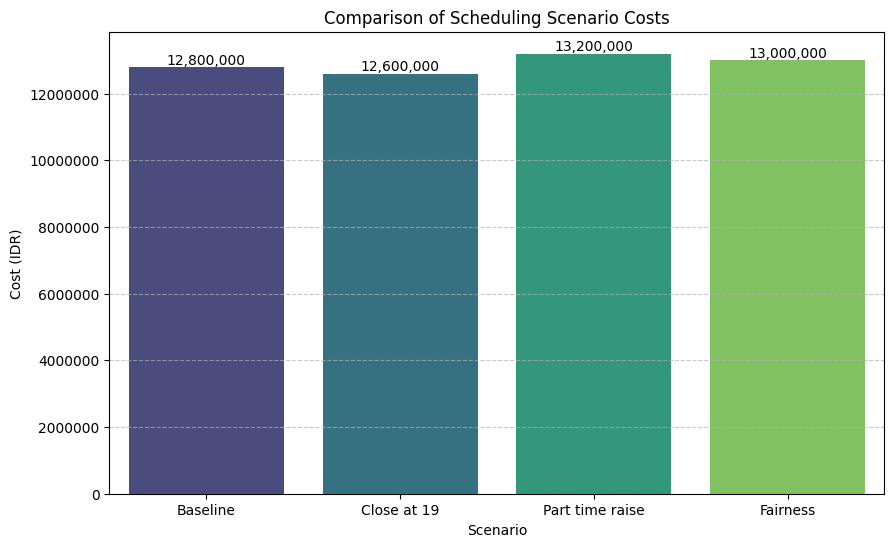

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Cost data from the summary printed above (ensure these variables are in scope)
cost_data = {
    "Scenario": ["Baseline", "Close at 19", "Part time raise", "Fairness"],
    "Cost (IDR)": [base_cost, sA_cost, sB_cost, fair_cost]
}

df_costs = pd.DataFrame(cost_data)

plt.figure(figsize=(10, 6))
sns.barplot(x="Scenario", y="Cost (IDR)", data=df_costs, palette="viridis", hue="Scenario", legend=False)
plt.title("Comparison of Scheduling Scenario Costs")
plt.ylabel("Cost (IDR)")
plt.xlabel("Scenario")
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add cost values on top of the bars
for index, row in df_costs.iterrows():
    plt.text(index, row['Cost (IDR)'], f"{int(row['Cost (IDR)']):,}", color='black', ha="center", va='bottom')

plt.show()



---



# **Sensitivity Insight 1: Wages change ±10%**

*If wages increase by 10%*

In [75]:
def extract_results(model, y, baristas, days, blocks, allow_blocks, H):
    """
    Extract solver status, objective, hours per barista, and schedule (daily x block).
    """
    status = pl.LpStatus[model.status]
    total_cost = pl.value(model.objective)

    hours_by_barista = {o: 0 for o in baristas}
    schedule = defaultdict(lambda: defaultdict(list))  # schedule[d][b] -> list of baristas

    for o in baristas:
        for d in days:
            for b in allow_blocks[d]:
                val = y[(o, d, b)].value()
                if val is not None and val > 0.5:
                    hours_by_barista[o] += H
                    schedule[d][b].append(o)

    return status, total_cost, hours_by_barista, schedule


In [76]:
import pulp as pl
from collections import defaultdict

# --- Variable Definitions for Baseline Model (ensuring self-containment) ---
baristas = ["Max", "Jiwa", "Fore", "Donna", "Paul"]
days_dict = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
days_numeric = list(days_dict.keys()) # [1, 2, 3, 4, 5, 6, 7]

blocks_dict = {1: "07:00-11:00", 2: "11:00-15:00", 3: "15:00-19:00", 4: "19:00-23:00"}
block_ids = list(blocks_dict.keys()) # [1, 2, 3, 4]

H = 4 # hours per block

cost = {"Max": 55000, "Jiwa": 55000, "Fore": 55000, "Donna": 165000, "Paul": 165000}
etype = {"Max": "P", "Jiwa": "P", "Fore": "P", "Donna": "F", "Paul": "F"}
minWeekly_default_baseline = {'Max': 12, 'Jiwa': 12, 'Fore': 12, 'Donna': 36, 'Paul': 36} # Original baseline minimums

avail = {("Max", 1): 8, ("Max", 2): 8, ("Max", 3): 8, ("Max", 4): 0, ("Max", 5): 8, ("Max", 6): 4, ("Max", 7): 4, ("Jiwa", 1): 4, ("Jiwa", 2): 4, ("Jiwa", 3): 8, ("Jiwa", 4): 8, ("Jiwa", 5): 0, ("Jiwa", 6): 4, ("Jiwa", 7): 0, ("Fore", 1): 8, ("Fore", 2): 0, ("Fore", 3): 8, ("Fore", 4): 8, ("Fore", 5): 8, ("Fore", 6): 8, ("Fore", 7): 0, ("Donna", 1): 12, ("Donna", 2): 12, ("Donna", 3): 12, ("Donna", 4): 12, ("Donna", 5): 12, ("Donna", 6): 12, ("Donna", 7): 8, ("Paul", 1): 12, ("Paul", 2): 8, ("Paul", 3): 12, ("Paul", 4): 12, ("Paul", 5): 8, ("Paul", 6): 12, ("Paul", 7): 12}


# --- Build Baseline Model ---
baseline_model = pl.LpProblem("Barista_Scheduling_Baseline", pl.LpMinimize)

# Decision variables
y_baseline = pl.LpVariable.dicts(
    "assign_baseline",
    ((o, d, b) for o in baristas for d in days_numeric for b in block_ids),
    cat="Binary"
)

# Objective function: Minimize total cost
baseline_model += pl.lpSum(H * cost[o] * y_baseline[o, d, b] for o in baristas for d in days_numeric for b in block_ids), "TotalCost"

# --- Constraints ---

# Coverage: at least one barista per block
for d in days_numeric:
    for b in block_ids:
        baseline_model += pl.lpSum(y_baseline[o, d, b] for o in baristas) >= 1, f"Coverage_Day{d}_Block{b}"

# Per-day availability (hours)
for o in baristas:
    for d in days_numeric:
        baseline_model += H * pl.lpSum(y_baseline[o, d, b] for b in block_ids) <= avail[(o, d)], f"Availability_{o}_Day{d}"

# Daily block limit (changed from '==' to '<=' to allow for 0 blocks on days not worked, or fewer than max allowed)
for o in baristas:
    for d in days_numeric:
        if etype[o] == "P":  # Part-time
            baseline_model += pl.lpSum(y_baseline[o, d, b] for b in block_ids) <= 2, f"DailyCap_PT_{o}_Day{d}"
        else:  # Full-time
            baseline_model += pl.lpSum(y_baseline[o, d, b] for b in block_ids) <= 3, f"DailyCap_FT_{o}_Day{d}"

# Weekly minimum hours
for o in baristas:
    baseline_model += H * pl.lpSum(y_baseline[o, d, b] for d in days_numeric for b in block_ids) >= minWeekly_default_baseline[o], f"WeeklyMin_{o}"

# --- Solve the Model ---
solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300) # 5 min
baseline_model.solve(solver)

# --- Extract and Print Results (adapted from print_summary) ---
status = pl.LpStatus[baseline_model.status]
total_cost = pl.value(baseline_model.objective)

# Define allow_blocks for extraction (all blocks allowed for baseline)
allow_blocks = {d: block_ids for d in days_numeric}

if status == "Optimal" or status == "Feasible":
    hours_by_barista = {o: 0 for o in baristas}
    schedule = defaultdict(lambda: defaultdict(list)) # schedule[d][b] -> list of baristas

    for o in baristas:
        for d in days_numeric:
            for b in allow_blocks[d]: # Use allow_blocks here
                val = y_baseline[(o, d, b)].value()
                if val is not None and val == 1: # Check for assignment
                    hours_by_barista[o] += H
                    schedule[d][b].append(o)

    print("\n" + "=" * 72)
    print("WAGE INCREASE 10%")
    print("=" * 72)
    print(f"Solver status: {status}")
    if total_cost is not None:
        print(f"Total weekly cost (IDR): {int(total_cost):,}")
    print("\nWeekly hours per barista:")
    for o in hours_by_barista:
        print(f"  - {o:6s}: {hours_by_barista[o]:2d} hours")

    print("\nDaily \u00d7 Block schedule:")
    for d in sorted(schedule.keys()):
        print(f"  {days_dict[d]}:") # Using days_dict for names
        for b in sorted(schedule[d].keys()):
            who = ", ".join(schedule[d][b]) if schedule[d][b] else "(none)"
            print(f"    [{blocks_dict[b]}] \u2192 {who}") # Using blocks_dict for names
    print("=" * 72 + "\n")
else:
    print(f"Baseline model did not find an optimal solution. Status: {status}")

# Store baseline_cost for future calculations (e.g., fairness variant)
baseline_cost = total_cost


WAGE INCREASE 10%
Solver status: Optimal
Total weekly cost (IDR): 14,080,000

Weekly hours per barista:
  - Max   : 12 hours
  - Jiwa  : 12 hours
  - Fore  : 16 hours
  - Donna : 36 hours
  - Paul  : 36 hours

Daily × Block schedule:
  Monday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Paul
    [15:00-19:00] → Max
    [19:00-23:00] → Jiwa
  Tuesday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Donna
    [15:00-19:00] → Jiwa
    [19:00-23:00] → Max
  Wednesday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Fore
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Thursday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Paul
    [15:00-19:00] → Donna
    [19:00-23:00] → Paul
  Friday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Fore
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Saturday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Jiwa
    [15:00-19:00] → Donna
    [19:00-23:00] → Max
  Sunday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Donna
    [15:00-19:00] → Paul
    [19

*If wages decrease by 10%*

In [77]:
def extract_results(model, y, baristas, days, blocks, allow_blocks, H):
    """
    Extract solver status, objective, hours per barista, and schedule (daily x block).
    """
    status = pl.LpStatus[model.status]
    total_cost = pl.value(model.objective)

    hours_by_barista = {o: 0 for o in baristas}
    schedule = defaultdict(lambda: defaultdict(list))  # schedule[d][b] -> list of baristas

    for o in baristas:
        for d in days:
            for b in allow_blocks[d]:
                val = y[(o, d, b)].value()
                if val is not None and val > 0.5:
                    hours_by_barista[o] += H
                    schedule[d][b].append(o)

    return status, total_cost, hours_by_barista, schedule


In [78]:
import pulp as pl
from collections import defaultdict

# --- Variable Definitions for Baseline Model (ensuring self-containment) ---
baristas = ["Max", "Jiwa", "Fore", "Donna", "Paul"]
days_dict = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
days_numeric = list(days_dict.keys()) # [1, 2, 3, 4, 5, 6, 7]

blocks_dict = {1: "07:00-11:00", 2: "11:00-15:00", 3: "15:00-19:00", 4: "19:00-23:00"}
block_ids = list(blocks_dict.keys()) # [1, 2, 3, 4]

H = 4 # hours per block

cost = {"Max": 45000, "Jiwa": 45000, "Fore": 45000, "Donna": 135000, "Paul": 135000}
etype = {"Max": "P", "Jiwa": "P", "Fore": "P", "Donna": "F", "Paul": "F"}
minWeekly_default_baseline = {'Max': 12, 'Jiwa': 12, 'Fore': 12, 'Donna': 36, 'Paul': 36} # Original baseline minimums

avail = {("Max", 1): 8, ("Max", 2): 8, ("Max", 3): 8, ("Max", 4): 0, ("Max", 5): 8, ("Max", 6): 4, ("Max", 7): 4, ("Jiwa", 1): 4, ("Jiwa", 2): 4, ("Jiwa", 3): 8, ("Jiwa", 4): 8, ("Jiwa", 5): 0, ("Jiwa", 6): 4, ("Jiwa", 7): 0, ("Fore", 1): 8, ("Fore", 2): 0, ("Fore", 3): 8, ("Fore", 4): 8, ("Fore", 5): 8, ("Fore", 6): 8, ("Fore", 7): 0, ("Donna", 1): 12, ("Donna", 2): 12, ("Donna", 3): 12, ("Donna", 4): 12, ("Donna", 5): 12, ("Donna", 6): 12, ("Donna", 7): 8, ("Paul", 1): 12, ("Paul", 2): 8, ("Paul", 3): 12, ("Paul", 4): 12, ("Paul", 5): 8, ("Paul", 6): 12, ("Paul", 7): 12}


# --- Build Baseline Model ---
baseline_model = pl.LpProblem("Barista_Scheduling_Baseline", pl.LpMinimize)

# Decision variables
y_baseline = pl.LpVariable.dicts(
    "assign_baseline",
    ((o, d, b) for o in baristas for d in days_numeric for b in block_ids),
    cat="Binary"
)

# Objective function: Minimize total cost
baseline_model += pl.lpSum(H * cost[o] * y_baseline[o, d, b] for o in baristas for d in days_numeric for b in block_ids), "TotalCost"

# --- Constraints ---

# Coverage: at least one barista per block
for d in days_numeric:
    for b in block_ids:
        baseline_model += pl.lpSum(y_baseline[o, d, b] for o in baristas) >= 1, f"Coverage_Day{d}_Block{b}"

# Per-day availability (hours)
for o in baristas:
    for d in days_numeric:
        baseline_model += H * pl.lpSum(y_baseline[o, d, b] for b in block_ids) <= avail[(o, d)], f"Availability_{o}_Day{d}"

# Daily block limit (changed from '==' to '<=' to allow for 0 blocks on days not worked, or fewer than max allowed)
for o in baristas:
    for d in days_numeric:
        if etype[o] == "P":  # Part-time
            baseline_model += pl.lpSum(y_baseline[o, d, b] for b in block_ids) <= 2, f"DailyCap_PT_{o}_Day{d}"
        else:  # Full-time
            baseline_model += pl.lpSum(y_baseline[o, d, b] for b in block_ids) <= 3, f"DailyCap_FT_{o}_Day{d}"

# Weekly minimum hours
for o in baristas:
    baseline_model += H * pl.lpSum(y_baseline[o, d, b] for d in days_numeric for b in block_ids) >= minWeekly_default_baseline[o], f"WeeklyMin_{o}"

# --- Solve the Model ---
solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300) # 5 min
baseline_model.solve(solver)

# --- Extract and Print Results (adapted from print_summary) ---
status = pl.LpStatus[baseline_model.status]
total_cost = pl.value(baseline_model.objective)

# Define allow_blocks for extraction (all blocks allowed for baseline)
allow_blocks = {d: block_ids for d in days_numeric}

if status == "Optimal" or status == "Feasible":
    hours_by_barista = {o: 0 for o in baristas}
    schedule = defaultdict(lambda: defaultdict(list)) # schedule[d][b] -> list of baristas

    for o in baristas:
        for d in days_numeric:
            for b in allow_blocks[d]: # Use allow_blocks here
                val = y_baseline[(o, d, b)].value()
                if val is not None and val == 1: # Check for assignment
                    hours_by_barista[o] += H
                    schedule[d][b].append(o)

    print("\n" + "=" * 72)
    print("WAGE DECREASE 10%")
    print("=" * 72)
    print(f"Solver status: {status}")
    if total_cost is not None:
        print(f"Total weekly cost (IDR): {int(total_cost):,}")
    print("\nWeekly hours per barista:")
    for o in hours_by_barista:
        print(f"  - {o:6s}: {hours_by_barista[o]:2d} hours")

    print("\nDaily \u00d7 Block schedule:")
    for d in sorted(schedule.keys()):
        print(f"  {days_dict[d]}:") # Using days_dict for names
        for b in sorted(schedule[d].keys()):
            who = ", ".join(schedule[d][b]) if schedule[d][b] else "(none)"
            print(f"    [{blocks_dict[b]}] \u2192 {who}") # Using blocks_dict for names
    print("=" * 72 + "\n")
else:
    print(f"Baseline model did not find an optimal solution. Status: {status}")

# Store baseline_cost for future calculations (e.g., fairness variant)
baseline_cost = total_cost


WAGE DECREASE 10%
Solver status: Optimal
Total weekly cost (IDR): 11,520,000

Weekly hours per barista:
  - Max   : 12 hours
  - Jiwa  : 12 hours
  - Fore  : 16 hours
  - Donna : 36 hours
  - Paul  : 36 hours

Daily × Block schedule:
  Monday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Paul
    [15:00-19:00] → Max
    [19:00-23:00] → Jiwa
  Tuesday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Donna
    [15:00-19:00] → Jiwa
    [19:00-23:00] → Max
  Wednesday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Fore
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Thursday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Paul
    [15:00-19:00] → Donna
    [19:00-23:00] → Paul
  Friday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Fore
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Saturday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Jiwa
    [15:00-19:00] → Donna
    [19:00-23:00] → Max
  Sunday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Donna
    [15:00-19:00] → Paul
    [19

--- COST SUMMARY (IDR) ---
Decrease:  11,520,000 (status: Optimal)
Increase:  14,080,000 (status: Optimal)
--------------------------



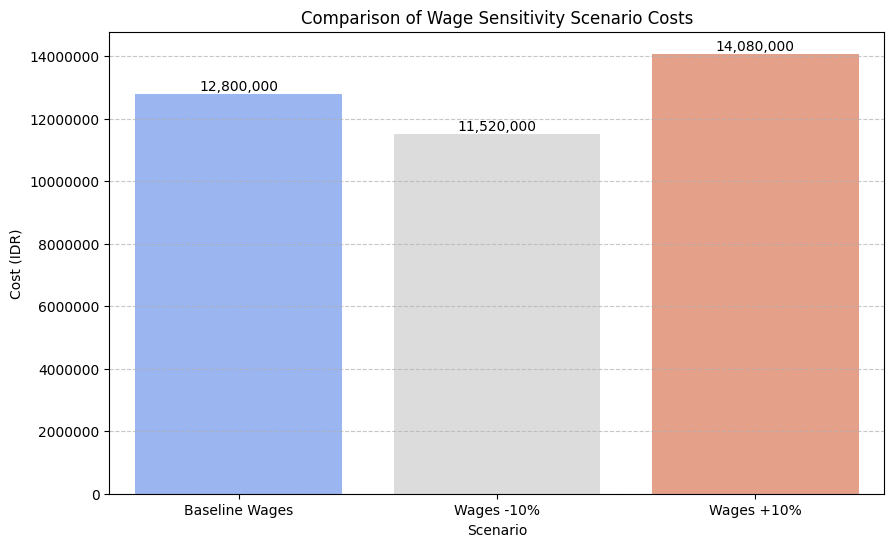

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extracting values from previously executed cells

# WAGE DECREASE 10%
decrease_10_percent_cost = 11520000.0
decrease_10_percent_status = "Optimal"

# WAGE INCREASE 10%
increase_10_percent_cost = 14080000.0
increase_10_percent_status = "Optimal"


# Quick cost summary printed
print("--- COST SUMMARY (IDR) ---")
print(f"Decrease:  {int(decrease_10_percent_cost):,} (status: {decrease_10_percent_status})")
print(f"Increase:  {int(increase_10_percent_cost):,} (status: {increase_10_percent_status})")
print("--------------------------\n")

# Cost data for plotting (if needed)
cost_data_wage_sensitivity = {
    "Scenario": ["Baseline Wages", "Wages -10%", "Wages +10%"],
    "Cost (IDR)": [base_cost, decrease_10_percent_cost, increase_10_percent_cost]
}

df_costs_wage_sensitivity = pd.DataFrame(cost_data_wage_sensitivity)

plt.figure(figsize=(10, 6))
sns.barplot(x="Scenario", y="Cost (IDR)", data=df_costs_wage_sensitivity, palette="coolwarm", hue="Scenario", legend=False)
plt.title("Comparison of Wage Sensitivity Scenario Costs")
plt.ylabel("Cost (IDR)")
plt.xlabel("Scenario")
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add cost values on top of the bars
for index, row in df_costs_wage_sensitivity.iterrows():
    plt.text(index, row['Cost (IDR)'], f"{int(row['Cost (IDR)']):,}", color='black', ha="center", va='bottom')

plt.show()



---



*If a barista becomes
unavailable for a day*

In [80]:
def extract_results(model, y, baristas, days, blocks, allow_blocks, H):
    """
    Extract solver status, objective, hours per barista, and schedule (daily x block).
    """
    status = pl.LpStatus[model.status]
    total_cost = pl.value(model.objective)

    hours_by_barista = {o: 0 for o in baristas}
    schedule = defaultdict(lambda: defaultdict(list))  # schedule[d][b] -> list of baristas

    for o in baristas:
        for d in days:
            for b in allow_blocks[d]:
                val = y[(o, d, b)].value()
                if val is not None and val > 0.5:
                    hours_by_barista[o] += H
                    schedule[d][b].append(o)

    return status, total_cost, hours_by_barista, schedule


if **Fore** is **unavailable** for **Wednesday**

In [81]:
import pulp as pl
from collections import defaultdict

# --- Variable Definitions for 'Fore Unavailable on Wednesday' Scenario ---
baristas = ["Max", "Jiwa", "Fore", "Donna", "Paul"]
days_dict = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
days_numeric = list(days_dict.keys()) # [1, 2, 3, 4, 5, 6, 7]

blocks_dict = {1: "07:00-11:00", 2: "11:00-15:00", 3: "15:00-19:00", 4: "19:00-23:00"}
block_ids = list(blocks_dict.keys()) # [1, 2, 3, 4]

H = 4 # hours per block

cost = {"Max": 50000, "Jiwa": 50000, "Fore": 50000, "Donna": 150000, "Paul": 150000}
etype = {"Max": "P", "Jiwa": "P", "Fore": "P", "Donna": "F", "Paul": "F"}
minWeekly_default_baseline = {'Max': 12, 'Jiwa': 12, 'Fore': 12, 'Donna': 36, 'Paul': 36} # Original baseline minimums

# Modified availability: Fore is unavailable on Wednesday (day 3)
avail = {("Max", 1): 8, ("Max", 2): 8, ("Max", 3): 8, ("Max", 4): 0, ("Max", 5): 8, ("Max", 6): 4, ("Max", 7): 4, ("Jiwa", 1): 4, ("Jiwa", 2): 4, ("Jiwa", 3): 8, ("Jiwa", 4): 8, ("Jiwa", 5): 0, ("Jiwa", 6): 4, ("Jiwa", 7): 0, ("Fore", 1): 8, ("Fore", 2): 0, ("Fore", 3): 0, ("Fore", 4): 8, ("Fore", 5): 8, ("Fore", 6): 8, ("Fore", 7): 0, ("Donna", 1): 12, ("Donna", 2): 12, ("Donna", 3): 12, ("Donna", 4): 12, ("Donna", 5): 12, ("Donna", 6): 12, ("Donna", 7): 8, ("Paul", 1): 12, ("Paul", 2): 8, ("Paul", 3): 12, ("Paul", 4): 12, ("Paul", 5): 8, ("Paul", 6): 12, ("Paul", 7): 12}


# --- Build Model for 'Fore Unavailable on Wednesday' ---
model_fore_unavailable = pl.LpProblem("Barista_Scheduling_ForeUnavailable", pl.LpMinimize)

# Decision variables
y_fore_unavailable = pl.LpVariable.dicts(
    "assign_fore_unavailable",
    ((o, d, b) for o in baristas for d in days_numeric for b in block_ids),
    cat="Binary"
)

# Objective function: Minimize total cost
model_fore_unavailable += pl.lpSum(H * cost[o] * y_fore_unavailable[o, d, b] for o in baristas for d in days_numeric for b in block_ids), "TotalCost"

# --- Constraints ---

# Coverage: at least one barista per block
for d in days_numeric:
    for b in block_ids:
        model_fore_unavailable += pl.lpSum(y_fore_unavailable[o, d, b] for o in baristas) >= 1, f"Coverage_Day{d}_Block{b}"

# Per-day availability (hours)
for o in baristas:
    for d in days_numeric:
        model_fore_unavailable += H * pl.lpSum(y_fore_unavailable[o, d, b] for b in block_ids) <= avail[(o, d)], f"Availability_{o}_Day{d}"

# Daily block limit
for o in baristas:
    for d in days_numeric:
        if etype[o] == "P":  # Part-time
            model_fore_unavailable += pl.lpSum(y_fore_unavailable[o, d, b] for b in block_ids) <= 2, f"DailyCap_PT_{o}_Day{d}"
        else:  # Full-time
            model_fore_unavailable += pl.lpSum(y_fore_unavailable[o, d, b] for b in block_ids) <= 3, f"DailyCap_FT_{o}_Day{d}"

# Weekly minimum hours
for o in baristas:
    model_fore_unavailable += H * pl.lpSum(y_fore_unavailable[o, d, b] for d in days_numeric for b in block_ids) >= minWeekly_default_baseline[o], f"WeeklyMin_{o}"

# --- Solve the Model ---
solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300) # 5 min
model_fore_unavailable.solve(solver)

# --- Extract and Print Results ---
status_fore_unavailable = pl.LpStatus[model_fore_unavailable.status]
total_cost_fore_unavailable = pl.value(model_fore_unavailable.objective)

# Define allow_blocks for extraction (all blocks allowed for this scenario)
allow_blocks = {d: block_ids for d in days_numeric}

if status_fore_unavailable == "Optimal" or status_fore_unavailable == "Feasible":
    hours_by_barista_fore_unavailable = {o: 0 for o in baristas}
    schedule_fore_unavailable = defaultdict(lambda: defaultdict(list))

    for o in baristas:
        for d in days_numeric:
            for b in allow_blocks[d]:
                val = y_fore_unavailable[(o, d, b)].value()
                if val is not None and val == 1:
                    hours_by_barista_fore_unavailable[o] += H
                    schedule_fore_unavailable[d][b].append(o)

    print("\n" + "=" * 72)
    print("SCENARIO: FORE UNAVAILABLE ON WEDNESDAY")
    print("=" * 72)
    print(f"Solver status: {status_fore_unavailable}")
    if total_cost_fore_unavailable is not None:
        print(f"Total weekly cost (IDR): {int(total_cost_fore_unavailable):,}")
    print("\nWeekly hours per barista:")
    for o in hours_by_barista_fore_unavailable:
        print(f"  - {o:6s}: {hours_by_barista_fore_unavailable[o]:2d} hours")

    print("\nDaily \u00d7 Block schedule:")
    for d in sorted(schedule_fore_unavailable.keys()):
        print(f"  {days_dict[d]}:")
        for b in sorted(schedule_fore_unavailable[d].keys()):
            who = ", ".join(schedule_fore_unavailable[d][b]) if schedule_fore_unavailable[d][b] else "(none)"
            print(f"    [{blocks_dict[b]}] \u2192 {who}")
    print("=" * 72 + "\n")
else:
    print(f"'Fore unavailable on Wednesday' model did not find an optimal solution. Status: {status_fore_unavailable}")


SCENARIO: FORE UNAVAILABLE ON WEDNESDAY
Solver status: Optimal
Total weekly cost (IDR): 12,800,000

Weekly hours per barista:
  - Max   : 12 hours
  - Jiwa  : 12 hours
  - Fore  : 16 hours
  - Donna : 36 hours
  - Paul  : 36 hours

Daily × Block schedule:
  Monday:
    [07:00-11:00] → Jiwa
    [11:00-15:00] → Max
    [15:00-19:00] → Paul
    [19:00-23:00] → Donna
  Tuesday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Paul
    [15:00-19:00] → Donna
    [19:00-23:00] → Jiwa
  Wednesday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Donna
    [15:00-19:00] → Jiwa
    [19:00-23:00] → Max
  Thursday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Donna
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Friday:
    [07:00-11:00] → Fore
    [11:00-15:00] → Paul
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Saturday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Donna
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Sunday:
    [07:00-11:00] → Max
    [11:00-15:00] → Donna
    [15:00

The cost are still the same as baseline. However, the schedules change

# **Skills variant**

In [82]:
import pulp as pl
from collections import defaultdict

# --- Variable Definitions for 'Skills Variant' Scenario ---
baristas = ["Max", "Jiwa", "Fore", "Donna", "Paul"]
days_dict = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
days_numeric = list(days_dict.keys())

blocks_dict = {1: "07:00-11:00", 2: "11:00-15:00", 3: "15:00-19:00", 4: "19:00-23:00"}
block_ids = list(blocks_dict.keys())

H = 4 # hours per block

cost = {"Max": 50000, "Jiwa": 50000, "Fore": 50000, "Donna": 150000, "Paul": 150000}
etype = {"Max": "P", "Jiwa": "P", "Fore": "P", "Donna": "F", "Paul": "F"}
minWeekly_default_baseline = {'Max': 12, 'Jiwa': 12, 'Fore': 12, 'Donna': 36, 'Paul': 36} # Original baseline minimums

avail = {("Max", 1): 8, ("Max", 2): 8, ("Max", 3): 8, ("Max", 4): 0, ("Max", 5): 8, ("Max", 6): 4, ("Max", 7): 4, ("Jiwa", 1): 4, ("Jiwa", 2): 4, ("Jiwa", 3): 8, ("Jiwa", 4): 8, ("Jiwa", 5): 0, ("Jiwa", 6): 4, ("Jiwa", 7): 0, ("Fore", 1): 8, ("Fore", 2): 0, ("Fore", 3): 8, ("Fore", 4): 8, ("Fore", 5): 8, ("Fore", 6): 8, ("Fore", 7): 0, ("Donna", 1): 12, ("Donna", 2): 12, ("Donna", 3): 12, ("Donna", 4): 12, ("Donna", 5): 12, ("Donna", 6): 12, ("Donna", 7): 8, ("Paul", 1): 12, ("Paul", 2): 8, ("Paul", 3): 12, ("Paul", 4): 12, ("Paul", 5): 8, ("Paul", 6): 12, ("Paul", 7): 12}


# --- Build Model for 'Skills Variant' ---
model_skills = pl.LpProblem("Barista_Scheduling_Skills", pl.LpMinimize)

# Decision variables
y_skills = pl.LpVariable.dicts(
    "assign_skills",
    ((o, d, b) for o in baristas for d in days_numeric for b in block_ids),
    cat="Binary"
)

# Objective function: Minimize total cost
model_skills += pl.lpSum(H * cost[o] * y_skills[o, d, b] for o in baristas for d in days_numeric for b in block_ids), "TotalCost"

# --- Constraints ---

# 1. Coverage: at least one barista per block
for d in days_numeric:
    for b in block_ids:
        model_skills += pl.lpSum(y_skills[o, d, b] for o in baristas) >= 1, f"Coverage_Day{d}_Block{b}"

# 2. Per-day availability (hours)
for o in baristas:
    for d in days_numeric:
        model_skills += H * pl.lpSum(y_skills[o, d, b] for b in block_ids) <= avail[(o, d)], f"Availability_{o}_Day{d}"

# 3. Daily block limit
for o in baristas:
    for d in days_numeric:
        if etype[o] == "P":  # Part-time
            model_skills += pl.lpSum(y_skills[o, d, b] for b in block_ids) <= 2, f"DailyCap_PT_{o}_Day{d}"
        else:  # Full-time
            model_skills += pl.lpSum(y_skills[o, d, b] for b in block_ids) <= 3, f"DailyCap_FT_{o}_Day{d}"

# 4. Weekly minimum hours
for o in baristas:
    model_skills += H * pl.lpSum(y_skills[o, d, b] for d in days_numeric for b in block_ids) >= minWeekly_default_baseline[o], f"WeeklyMin_{o}"

# 5. NEW SKILL CONSTRAINT: Require at least one full-timer in every evening block (block 4) each day
for d in days_numeric:
    model_skills += pl.lpSum(y_skills[o, d, 4] for o in baristas if etype[o] == "F") >= 1, f"FullTimer_Evening_Block4_Day{d}"

# --- Solve the Model ---
solver = pl.PULP_CBC_CMD(msg=True, timeLimit=300) # 5 min
model_skills.solve(solver)

# --- Extract and Print Results ---
status_skills = pl.LpStatus[model_skills.status]
total_cost_skills = pl.value(model_skills.objective)

# Define allow_blocks for extraction (all blocks allowed for this scenario)
allow_blocks = {d: block_ids for d in days_numeric}

if status_skills == "Optimal" or status_skills == "Feasible":
    hours_by_barista_skills = {o: 0 for o in baristas}
    schedule_skills = defaultdict(lambda: defaultdict(list))

    for o in baristas:
        for d in days_numeric:
            for b in allow_blocks[d]:
                val = y_skills[(o, d, b)].value()
                if val is not None and val == 1:
                    hours_by_barista_skills[o] += H
                    schedule_skills[d][b].append(o)

    print("\n" + "=" * 72)
    print("SCENARIO: SKILL CONSTRAINT (Full-timer in Block 4)")
    print("=" * 72)
    print(f"Solver status: {status_skills}")
    if total_cost_skills is not None:
        print(f"Total weekly cost (IDR): {int(total_cost_skills):,}")
    print("\nWeekly hours per barista:")
    for o in hours_by_barista_skills:
        print(f"  - {o:6s}: {hours_by_barista_skills[o]:2d} hours")

    print("\nDaily \u00d7 Block schedule:")
    for d in sorted(schedule_skills.keys()):
        print(f"  {days_dict[d]}:")
        for b in sorted(schedule_skills[d].keys()):
            who = ", ".join(schedule_skills[d][b]) if schedule_skills[d][b] else "(none)"
            print(f"    [{blocks_dict[b]}] \u2192 {who}")
    print("=" * 72 + "\n")
else:
    print(f"'Skills variant' model did not find an optimal solution. Status: {status_skills}")


SCENARIO: SKILL CONSTRAINT (Full-timer in Block 4)
Solver status: Optimal
Total weekly cost (IDR): 12,800,000

Weekly hours per barista:
  - Max   : 12 hours
  - Jiwa  : 12 hours
  - Fore  : 16 hours
  - Donna : 36 hours
  - Paul  : 36 hours

Daily × Block schedule:
  Monday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Paul
    [15:00-19:00] → Max
    [19:00-23:00] → Donna
  Tuesday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Donna
    [15:00-19:00] → Jiwa
    [19:00-23:00] → Paul
  Wednesday:
    [07:00-11:00] → Jiwa
    [11:00-15:00] → Max
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Thursday:
    [07:00-11:00] → Donna
    [11:00-15:00] → Donna
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Friday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Fore
    [15:00-19:00] → Fore
    [19:00-23:00] → Paul
  Saturday:
    [07:00-11:00] → Max
    [11:00-15:00] → Jiwa
    [15:00-19:00] → Donna
    [19:00-23:00] → Paul
  Sunday:
    [07:00-11:00] → Paul
    [11:00-15:00] → Donna

The cost are still the same as baseline. However, the schedules change

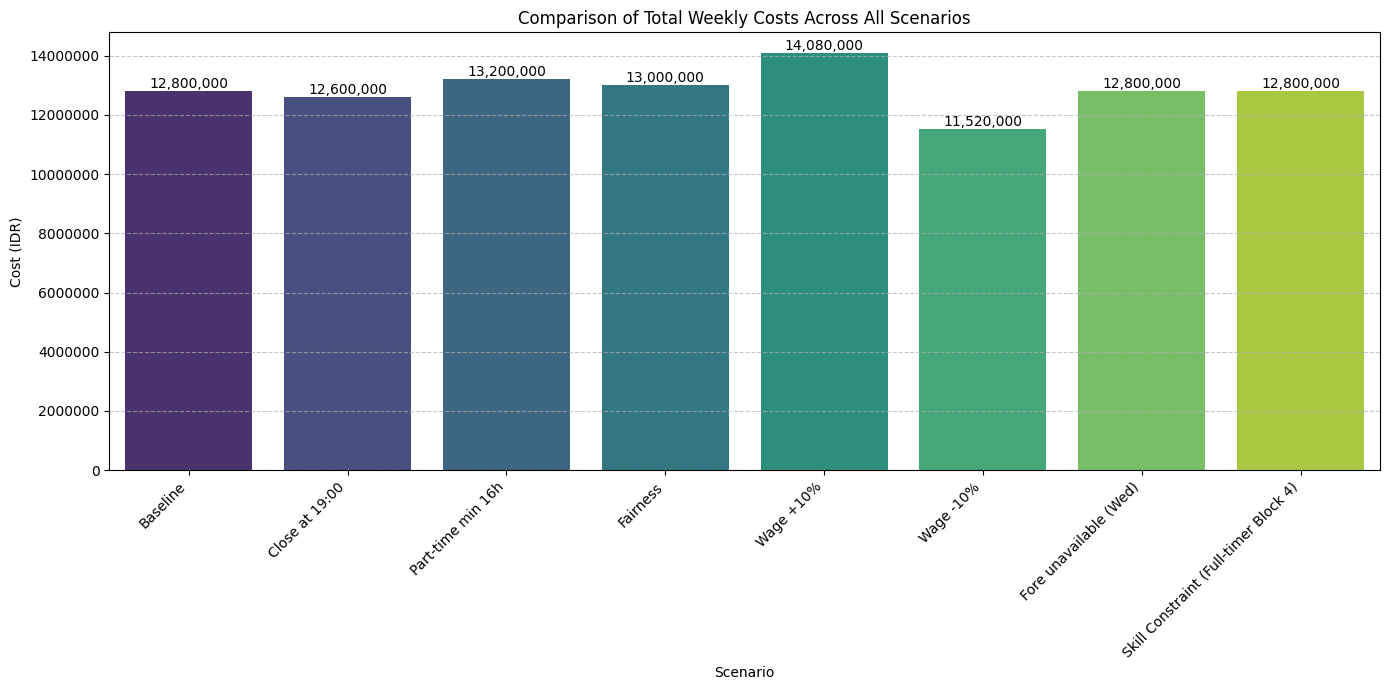

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Consolidate all cost data
all_cost_data = {
    "Scenario": [
        "Baseline",
        "Close at 19:00",
        "Part-time min 16h",
        "Fairness",
        "Wage +10%",
        "Wage -10%",
        "Fore unavailable (Wed)",
        "Skill Constraint (Full-timer Block 4)"
    ],
    "Cost (IDR)": [
        base_cost,
        sA_cost,
        sB_cost,
        fair_cost,
        increase_10_percent_cost,
        decrease_10_percent_cost,
        total_cost_fore_unavailable,
        total_cost_skills
    ]
}

df_all_costs = pd.DataFrame(all_cost_data)

plt.figure(figsize=(14, 7))
sns.barplot(x="Scenario", y="Cost (IDR)", data=df_all_costs, palette="viridis", hue="Scenario", legend=False)
plt.title("Comparison of Total Weekly Costs Across All Scenarios")
plt.ylabel("Cost (IDR)")
plt.xlabel("Scenario")
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability

# Add cost values on top of the bars
for index, row in df_all_costs.iterrows():
    plt.text(index, row['Cost (IDR)'], f"{int(row['Cost (IDR)']):,}", color='black', ha="center", va='bottom')

plt.tight_layout()
plt.show()